In [1]:
from typing import List, Tuple
from functools import lru_cache

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [2]:
api = wandb.Api()

In [3]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [4]:
keys = [
    "policy_stats/avg_score", 
    # "policy_stats/avg_experience_points", 
    # "policy_stats/avg_experience_level", 
    # "policy_stats/avg_max_energy", 
    # "policy_stats/avg_max_hitpoints", 
    # "policy_stats/avg_eating_score", 
    # "policy_stats/avg_turns", 
    # "policy_stats/avg_staircase_score", 
    # "policy_stats/avg_staircase_pet_score", 
    # "policy_stats/avg_armor_class", 
    # "policy_stats/avg_scout_score", 
    # "policy_stats/avg_dlvl", 
    # "policy_stats/avg_sokobanfillpit_score", 
    # "policy_stats/avg_gold_score", 
    "train/env_steps",
]

In [5]:
def get_experiment_data(name, filters):
    runs = api.runs("bartekcupial/sf2_nethack", filters=filters)
    data = []
    for run in runs:
        try:
            df = run.history(samples=30000, keys=keys)
            df = pd.DataFrame(df)
            df["seed"] = run.config["seed"]
            df["name"] = name
            data.append(df)
        except Exception as e:
            pass

    data = pd.concat(data, axis=0).reset_index()
    
    return data

In [6]:
appo_df = get_experiment_data(
    "appo", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-baseline']", "config.learning_rate": 0.0001}
)

In [7]:
appo_t_df = get_experiment_data(
    "appo_t", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-T-baseline']"}
)

In [8]:
appo_ks_t_df = get_experiment_data(
    "appo_ks_t", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-KS-T-baseline']", "config.kickstarting_loss_decay": 0.99998}
)

In [9]:
appo_bc_t_df = get_experiment_data(
    "appo_bc_t", 
    {"config.exp_tags": "['2024_01_23_monk-APPO-BC-T-baseline']"}
)

In [10]:
data = pd.concat([appo_df, appo_t_df, appo_ks_t_df, appo_bc_t_df], axis=0).reset_index()

In [11]:
data

,level_0,index,_step,policy_stats/avg_score,train/env_steps,seed,name
0,0,0,4,0.240000,77824.0,0,appo
1,1,1,26,0.900000,630784.0,0,appo
2,2,2,47,6.530000,1171456.0,0,appo
3,3,3,68,32.560001,1712128.0,0,appo
4,4,4,89,69.480003,2232320.0,0,appo
...,...,...,...,...,...,...,...
19795,7797,1555,5051,4616.399902,553594880.0,1,appo_bc_t
19796,7798,1556,5052,4609.240234,553594880.0,1,appo_bc_t
19797,7799,1557,5054,4604.450195,554024960.0,1,appo_bc_t
19798,7800,1558,5056,4733.060059,554459136.0,1,appo_bc_t


In [12]:
data["index"] = data["train/env_steps"] - data["train/env_steps"] % 5_000_000

In [13]:
data.loc[data["name"] != "appo", "index"] = data[data["name"] != "appo"]["index"] - 25_000_000

In [14]:
data[(data['index'] == 0) & (data['name'].str.contains('_t'))]

,level_0,index,_step,policy_stats/avg_score,train/env_steps,seed,name
4145,0,0.0,28,5121.299805,25038848.0,1,appo_t
4146,1,0.0,51,5193.339844,25849856.0,1,appo_t
4147,2,0.0,73,5217.180176,26660864.0,1,appo_t
4148,3,0.0,94,5773.819824,27467776.0,1,appo_t
4149,4,0.0,114,5885.509766,28266496.0,1,appo_t
...,...,...,...,...,...,...,...
18250,6252,0.0,223,4735.950195,28565504.0,1,appo_bc_t
18251,6253,0.0,239,4465.060059,28913664.0,1,appo_bc_t
18252,6254,0.0,254,4173.120117,29245440.0,1,appo_bc_t
18253,6255,0.0,269,4236.189941,29585408.0,1,appo_bc_t


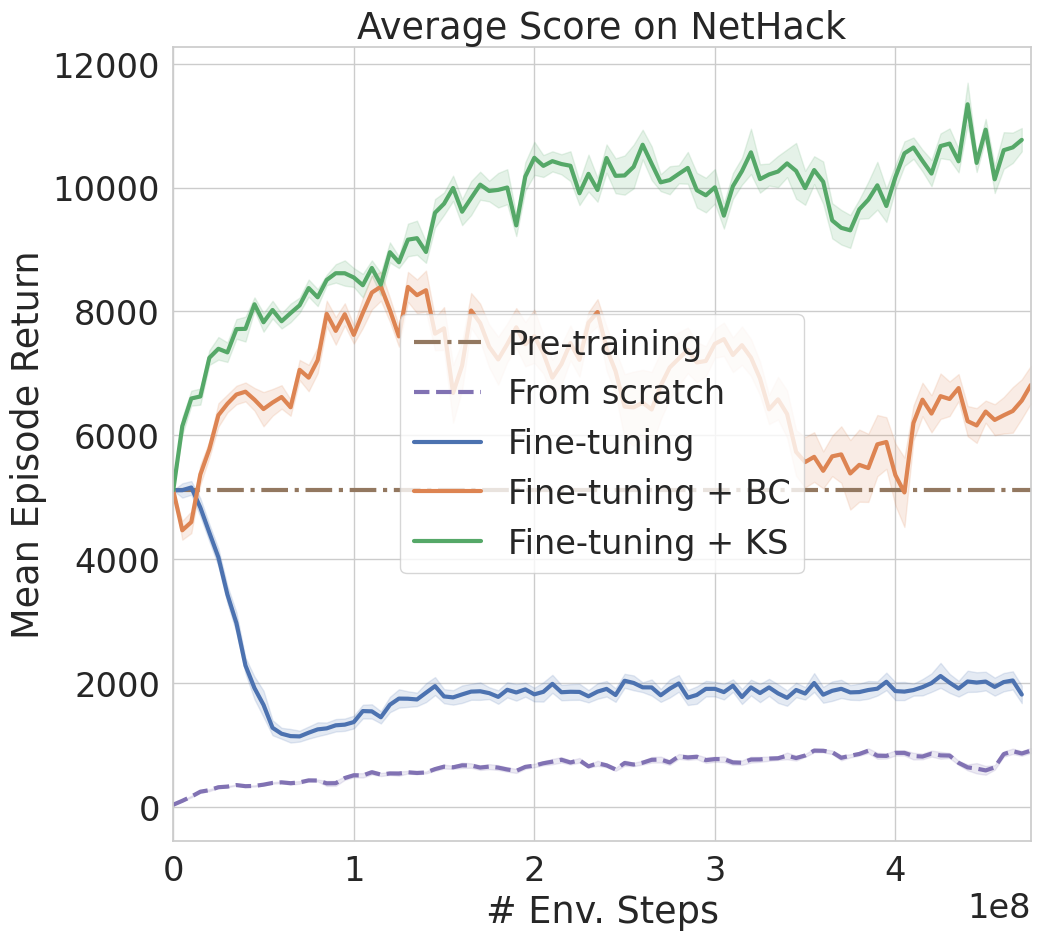

In [15]:
n_rows = 1
n_cols = 1
sns.set(font_scale=2.2)
sns.set_style('whitegrid')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 10))

# axes = axes.flatten()
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

method_translator = {
    "appo": "From scratch",
    "appo_t": "Fine-tuning",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ks_t": "Fine-tuning + KS",

}


sns_colors = sns.color_palette()
# sns_colors = sns_colors[]
colors = {
    "From scratch": sns_colors[4],
    "Fine-tuning": sns_colors[0],
    "Fine-tuning + BC": sns_colors[1],
    "Fine-tuning + KS": sns_colors[2],
}

eval_column = "policy_stats/avg_score"

# [0 - 500M]
baseline_val = data[(data['index'] == 0) & (data['name'].str.contains('_t'))][eval_column].mean()
axes.plot([0, 500_000_000], [baseline_val, baseline_val], linestyle='-.', label="Pre-training", linewidth=3, color=sns_colors[5])
for e, (method, method_name) in enumerate(method_translator.items()):

    method_data = data[data["name"] == method]
    method_data = method_data.replace('NaN', pd.NA).dropna()

    if '_t' in method:
        method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

    legend = "full"
    sns.lineplot(data=method_data, x="index", y=eval_column, ax=axes, errorbar=('ci', 90), linewidth=3,
                    legend=legend, label=method_name, linestyle="-" if method_name != "From scratch" else "--",
                    err_kws={"alpha": .15}, color=colors[method_name])

    axes.set_ylabel("Mean Episode Return")

    axes.set_xlabel("# Env. Steps")
    axes.set_xlim(0, 475_000_000)

    axes.set_title(f"Average Score on NetHack")

plt.tight_layout()

# Show or save the plot
plt.show()